This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

Defining our source

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.0478E+04 G

Coronal Particle Number Density:
 n_c = 3.4392E+10 cm-3

Coronal Temperature:
 T_c = 2.5282E+09 K

Width of the current sheet:
 delta_RX = 1.6649E+11 cm

Reconnection Power:
 wdot_B = 5.9912E+42 erg s-1


In [4]:
# Load the data from the CSV files
archival_data = pd.read_csv('observed_SED/archival_data.csv', header=None)
magic_data = pd.read_csv('observed_SED/4FGL_MAGIC_data.csv', header=None)
icecube_data = pd.read_csv('observed_SED/IceCube_neutrinos_data.csv', header=None)

In [5]:
magic_data

,0,1
0,0.070006,6.951928e-13
1,0.176924,9.131168e-13
2,0.553813,9.701572e-13
3,1.733557,5.292784e-13
4,5.426418,2.717756e-13
5,16.985897,5.292784e-13
6,94.070040,4.029611e-13
7,94.070040,2.266017e-13
8,316.227766,1.095150e-12
9,316.227766,6.158482e-13


In [6]:
# Remove the rows with indices 7, 9, 11, 13, and 15
indices_to_remove = [7, 9, 11, 13, 15]
magic_data_cleaned = magic_data.drop(indices_to_remove, axis=0).reset_index(drop=True)

# Use .iloc for positional indexing
data_4FGL_DR2 = magic_data_cleaned.iloc[:7]  # First 7 points
data_MAGIC = magic_data_cleaned.iloc[7:]     # Remaining points

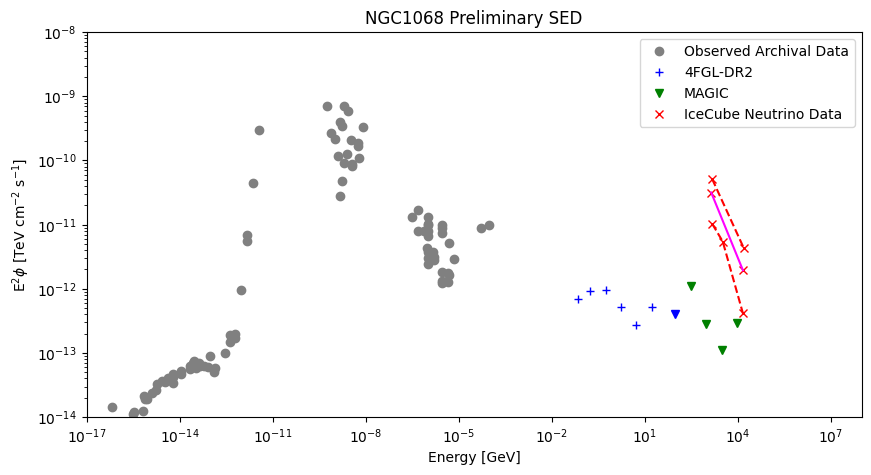

In [7]:
plt.figure(figsize=(10, 5))

## Archival data
plt.plot(archival_data[0], archival_data[1], 'o', label='Observed Archival Data', color='gray')

## 4FGL & MAGIC data
# plt.plot(magic_data[0], magic_data[1], 's', label='4FGL & MAGIC Data', color='green')

## Plot the first 6 points with '+'
plt.plot(data_4FGL_DR2.iloc[:6, 0], data_4FGL_DR2.iloc[:6, 1], '+', label='4FGL-DR2', color='blue')

## Plot the 7th point with 'v'
plt.plot(data_4FGL_DR2.iloc[6, 0], data_4FGL_DR2.iloc[6, 1], 'v', color='blue')

## Plot the remaining points with 'v' in a different color
plt.plot(data_MAGIC.iloc[:, 0], data_MAGIC.iloc[:, 1], 'v', label='MAGIC', color='green')

## IceCube Neutrino data
plt.plot(icecube_data[0], icecube_data[1], 'x', label='IceCube Neutrino Data', color='red')
plt.plot(icecube_data[0][0:2], icecube_data[1][0:2], '--', color='red')
plt.plot(icecube_data[0][2:4], icecube_data[1][2:4], '-', color='magenta')
plt.plot(icecube_data[0][4:7], icecube_data[1][4:7], '--', color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-17, 1e8)
plt.ylim(1e-14, 1e-8)
plt.xlabel('Energy [GeV]')
plt.ylabel(r'E$^2 \phi$ [TeV cm$^{-2}$ s$^{-1}$]')
plt.title('NGC1068 Preliminary SED')

plt.legend()

plt.savefig('plots/preliminary_SED.png',dpi=300)

plt.show()
